_python notebook №3_

## Стадия обученяи сетей DenseNet 121 с применением Transfer learning

In [1]:
import nbimporter
import datasets_bilder # загрузка datasets_bilder.py из репозитория

In [2]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os
import random
import seaborn as sns
import torch, torchvision
from  matplotlib import pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools
import torchvision.utils as vutils
%matplotlib inline

In [3]:
# Для воспроизводимости результатов зафиксируем сиды:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

Функция для отображения картинок

In [4]:
def imshow(img):
    img = img *std_nums[0] + mean_nums[0]  
    img = img.cpu().numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))  
    plt.show()

Функция для визуализации confusion_matrix:

In [5]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

## DenseNet121

Загрузим предобученную модель. DenseNet архитектура состоит из четырех плотных блоков с разным количеством слоев.В случае DenseNet-121 [6,12,24,16] слоев в четырех плотных блоках

In [7]:
model = torchvision.models.densenet121(pretrained=True)

D:\Program files 2.0\Anaconda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Program files 2.0\Anaconda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\Дмитрий/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [8]:
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

У данной сети представлен лишь 1 слой полносвязный под названием classifier с выходным числом нейронов равным 1000. В нашем случае решается задача бинарной классификации, так что данный слой будет иметь по 2 нейрона на выходе.

## _Рассмотрим какие эксперименты мы будем проводить с данной сетью:_

__1) Зафиксируем полностью все сверточные слои и лишь обучим полносвязные слои.__ <br>При этом я поменяю архитектуру полносвязного слоя fc. Я сделаю один скрытый слой с числом нейронов, которое будет в качестве подбираемого гиперпараметра.  Лучший гиперпараметр определим по результатам accuracy на валидационной выборке. <br>Так как фотки исходные чб, то при создании датасетов буду включать параметр RGB_presentation = True, который сделает входные фотки размером (3, 224, 224)

__2) Зафиксируем все сверточные слои кроме первого входного, в котором установим число входных каналов равным 1 вместо 3 + обучим полносвязные слои.__<br>
При этом я поменяю архитектуру полносвязного слоя fc. Я сделаю один скрытый слой с числом нейронов, которое будет в качестве подбираемого гиперпараметра. Лучший гиперпараметр определим по результатам accuracy на валидационной выборке. <br>Так как я поменяю чило каналов на входе сети, поэтому могу обучать на чб снимках, размером (1, 224, 224).


__3) Полностью обучим сеть, ничего в ней не меняя (кроме выходного числа нейронов в полносвязной части).__<br>
Так как фотки исходные чб, то при создании датасетов буду включать параметр RGB_presentation = True, который сделает входные фотки размером (3, 224, 224)

## №1

In [9]:
model.classifier.in_features

1024

In [10]:
n_neurons = 10
# Переопредлим полносвязные слои:
fc_new =  nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1024, n_neurons),
            nn.ReLU(),
            nn.Linear(n_neurons, 2))

В таком виде переопределим сеть:

In [11]:
model.classifier = fc_new
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

Создадим папку, куда загрузим модели:

In [12]:
directory = os.getcwd() + '\models'
if not os.path.exists(directory):
    os.makedirs(directory)

__Проведем обучение 10 эпох для каждого значения подбираемого гиперпараметра:__

Я сделаю один скрытый слой в новом classifier layer с числом нейронов, которое будет в качестве подбираемого гиперпараметра. Лучший гиперпараметр определю по результатам accuracy на валидационной выборке + построю графики изменения метрик accuracy и loss в процессе обучения для каждого значения гиперпараметра. <br> Значения пербираемые n_neurons = 10, 100 и 500

In [37]:
n_neurons_list = [10, 100, 500]

In [14]:
data = datasets_bilder.preprocessing_func(RGB_presentation=True, easy=True)
dataset_test = data.test
dataset_train = data.train
dataset_val = data.val
mean_nums = data.mean_nums
std_nums = data.std_nums
batch_size = 30
train_dataloader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=True, num_workers=0)

In [15]:
directory = os.getcwd() + '\models'
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def accuracy(output,labels):
    predictions = torch.argmax(output,dim=1)
    correct = (predictions == labels).sum().cpu().numpy()
    return correct / len(labels)

In [16]:
# Задаим словари для отслеживания метрик accuracy и loss в процессе обучения для каждого значения гиперпараметра.
loss_train_dict = {}
acc_train_dict = {}
acc_validation_dict = {}
loss_validation_dict = {}

n_epoch = 10 #Зададим число эпох обучения
start_time = time.time()
for n_neurons in n_neurons_list:
    model = torchvision.models.densenet121(pretrained=True).to(device)
    # Переопредлим полносвязные слои:
    fc_new =  nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1024, n_neurons),
            nn.ReLU(),
            nn.Linear(n_neurons, 2))
    
    model.classifier = fc_new
    # Зафиксируем все слои кроме переназначенного fc
    for name, param in model.named_parameters():
        if not ('classifier' in name):
            param.requires_grad = False
    
    loss_func = nn.CrossEntropyLoss().to(device) #Функция поторь

    opt = optim.Adam(model.parameters(), lr=0.001) # Адам-оптимизатор
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=5, gamma=0.1)
    
    # Заведем листы, в которые будем сохранять данные loss и acc эпох обучения
    loss_train = []
    acc_train = []
    acc_validation = []
    loss_validation = []
    
    
    maxacc = 0 
    print('НАЧИНАЕТСЯ ОБУЧЕНИЕ МОДЕЛИ С n_neurons =', n_neurons, ':')
    for epoch in range(n_epoch): # цикл эпох
        model.train()
        running_loss = 0.0
        running_acc = 0.0
        for batch in tqdm(train_dataloader):
            # получим данные батча
            image_batch, label_batch  = batch
            image_batch, label_batch = image_batch.to(device), label_batch.to(device)

            #Приведу значение label_batch к требуемому виду
            label_batch = torch.flatten(label_batch).type(torch.LongTensor) 

            # обнуление параметров градиента
            opt.zero_grad()

            # forward + backward + optimize
            y_pred = model(image_batch)
            loss = loss_func(y_pred, label_batch)

            loss.backward()
            opt.step()

            #среднее по так будем искать (складывать а потом делить число батчей):
            running_loss += loss.item() 
            running_acc += accuracy(y_pred, label_batch)

        print("[epoch {}] loss: {:.3}, acc: {:.3}".format(epoch+1, running_loss / len(train_dataloader),
                                                          running_acc / len(train_dataloader)))
        loss_train.append(running_loss / len(train_dataloader))
        acc_train.append(running_acc / len(train_dataloader))
        scheduler.step() # шаг для lr_scheduler

        model.eval()  #Перевод модели в режим тестирования
        acc_val = []
        running_loss_val = 0
        for itr,data in enumerate(val_dataloader):
                imgs = data[0].to(device)
                labels = data[1].to(device)   
                labels = torch.flatten(labels).type(torch.LongTensor)
                y_pred = model(imgs)
                acc_val.append(accuracy(y_pred,labels))
                running_loss_val += loss.item()
        loss_val_ep =  running_loss_val / len(val_dataloader)

        acc_val_ep = np.mean(np.array(acc_val))
        print(f'Validation accuracy - {acc_val_ep}')
        acc_validation.append(acc_val_ep)
        loss_validation.append(loss_val_ep)


        # Сохраним текущую модель лишь в случае более высокого accuracy на валидации:
        if np.mean(np.array(acc_val)) > maxacc:
                maxacc = np.mean(np.array(acc_val)) 
                torch.save(model, directory+'\model_DenseNet121_1_n='+str(n_neurons)+'.pth')
                
    print('ЗАВЕРШИЛОСЬ ОБУЧЕНИЕ МОДЕЛИ С n_neurons =', n_neurons)    
    
    # Добавим в словари значения изменения метрик в процессе обучения для текущего значения гиперпараметра
    loss_train_dict[n_neurons] = loss_train
    acc_train_dict[n_neurons] = acc_train
    acc_validation_dict[n_neurons] = acc_validation
    loss_validation_dict[n_neurons] = loss_validation
        
print('Total time {:.1f} seconds'.format(time.time() - start_time))

НАЧИНАЕТСЯ ОБУЧЕНИЕ МОДЕЛИ С n_neurons = 10 :


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [28:36<00:00,  9.59s/it]


[epoch 1] loss: 0.295, acc: 0.885
Validation accuracy - 0.8515151515151516


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [28:46<00:00,  9.64s/it]


[epoch 2] loss: 0.185, acc: 0.932
Validation accuracy - 0.8424242424242425


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [28:38<00:00,  9.60s/it]


[epoch 3] loss: 0.155, acc: 0.939
Validation accuracy - 0.893939393939394


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [27:56<00:00,  9.37s/it]


[epoch 4] loss: 0.158, acc: 0.938
Validation accuracy - 0.8606060606060608


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [27:47<00:00,  9.32s/it]


[epoch 5] loss: 0.153, acc: 0.944
Validation accuracy - 0.8787878787878789


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [27:52<00:00,  9.34s/it]


[epoch 6] loss: 0.137, acc: 0.949
Validation accuracy - 0.8666666666666667


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [27:49<00:00,  9.33s/it]


[epoch 7] loss: 0.136, acc: 0.949
Validation accuracy - 0.8606060606060606


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [28:05<00:00,  9.41s/it]


[epoch 8] loss: 0.127, acc: 0.951
Validation accuracy - 0.8727272727272729


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [28:08<00:00,  9.43s/it]


[epoch 9] loss: 0.132, acc: 0.951
Validation accuracy - 0.8742424242424243


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [27:53<00:00,  9.35s/it]


[epoch 10] loss: 0.135, acc: 0.949
Validation accuracy - 0.8787878787878788
ЗАВЕРШИЛОСЬ ОБУЧЕНИЕ МОДЕЛИ С n_neurons = 10
НАЧИНАЕТСЯ ОБУЧЕНИЕ МОДЕЛИ С n_neurons = 100 :


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [27:54<00:00,  9.35s/it]


[epoch 1] loss: 0.24, acc: 0.898
Validation accuracy - 0.8257575757575758


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [27:53<00:00,  9.35s/it]


[epoch 2] loss: 0.166, acc: 0.935
Validation accuracy - 0.8454545454545453


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [28:15<00:00,  9.47s/it]


[epoch 3] loss: 0.15, acc: 0.944
Validation accuracy - 0.8424242424242425


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [28:03<00:00,  9.41s/it]


[epoch 4] loss: 0.159, acc: 0.939
Validation accuracy - 0.8878787878787879


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [28:11<00:00,  9.45s/it]


[epoch 5] loss: 0.15, acc: 0.944
Validation accuracy - 0.8757575757575758


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [28:41<00:00,  9.62s/it]


[epoch 6] loss: 0.13, acc: 0.95
Validation accuracy - 0.8757575757575758


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [28:55<00:00,  9.69s/it]


[epoch 7] loss: 0.125, acc: 0.954
Validation accuracy - 0.8666666666666667


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [28:10<00:00,  9.44s/it]


[epoch 8] loss: 0.129, acc: 0.948
Validation accuracy - 0.8742424242424243


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [28:10<00:00,  9.44s/it]


[epoch 9] loss: 0.138, acc: 0.946
Validation accuracy - 0.8606060606060608


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [28:20<00:00,  9.50s/it]


[epoch 10] loss: 0.124, acc: 0.955
Validation accuracy - 0.8575757575757575
ЗАВЕРШИЛОСЬ ОБУЧЕНИЕ МОДЕЛИ С n_neurons = 100
НАЧИНАЕТСЯ ОБУЧЕНИЕ МОДЕЛИ С n_neurons = 500 :


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [28:23<00:00,  9.52s/it]


[epoch 1] loss: 0.246, acc: 0.899
Validation accuracy - 0.8818181818181817


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [28:35<00:00,  9.58s/it]


[epoch 2] loss: 0.172, acc: 0.932
Validation accuracy - 0.859090909090909


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [28:39<00:00,  9.61s/it]


[epoch 3] loss: 0.169, acc: 0.935
Validation accuracy - 0.8878787878787879


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [28:33<00:00,  9.57s/it]


[epoch 4] loss: 0.152, acc: 0.942
Validation accuracy - 0.868181818181818


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [28:40<00:00,  9.61s/it]


[epoch 5] loss: 0.144, acc: 0.945
Validation accuracy - 0.8742424242424243


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [28:39<00:00,  9.61s/it]


[epoch 6] loss: 0.133, acc: 0.948
Validation accuracy - 0.8878787878787879


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [28:45<00:00,  9.64s/it]


[epoch 7] loss: 0.112, acc: 0.957
Validation accuracy - 0.8727272727272729


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [28:41<00:00,  9.62s/it]


[epoch 8] loss: 0.129, acc: 0.95
Validation accuracy - 0.8787878787878789


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [28:43<00:00,  9.63s/it]


[epoch 9] loss: 0.116, acc: 0.954
Validation accuracy - 0.8863636363636364


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [28:37<00:00,  9.59s/it]


[epoch 10] loss: 0.117, acc: 0.956
Validation accuracy - 0.8621212121212122
ЗАВЕРШИЛОСЬ ОБУЧЕНИЕ МОДЕЛИ С n_neurons = 500
Total time 53639.9 seconds


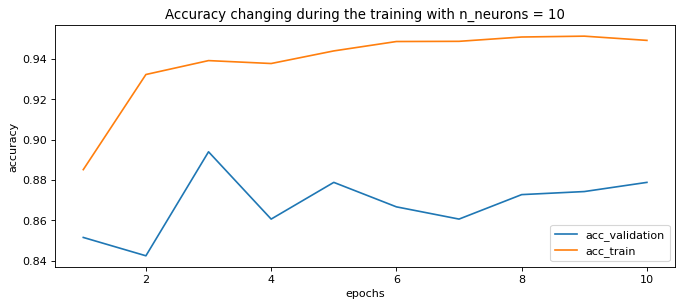

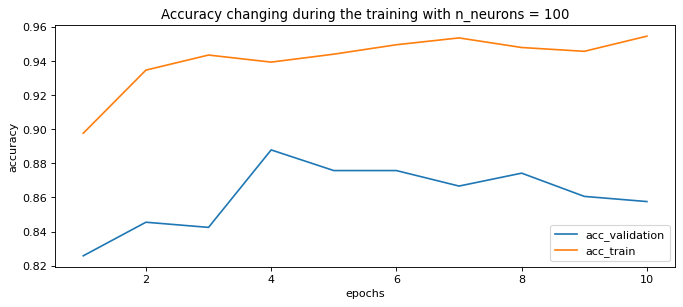

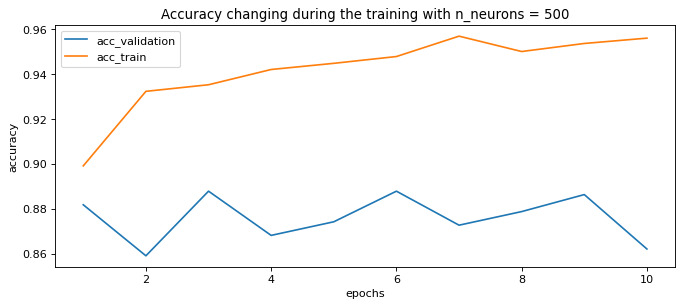

In [18]:
for i in n_neurons_list:
    acc_validation = acc_validation_dict[i]
    acc_train = acc_train_dict[i]
    plt.figure(figsize=(10, 4), dpi=80)
    plt.title('Accuracy changing during the training with n_neurons = ' + str(i))  
    plt.plot(list(range(1, n_epoch+1)), acc_validation, label='acc_validation')
    plt.plot(list(range(1, n_epoch+1)), acc_train, label='acc_train')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend(loc='best')  
    plt.show()

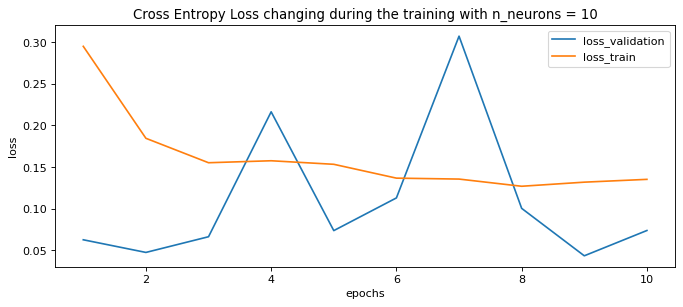

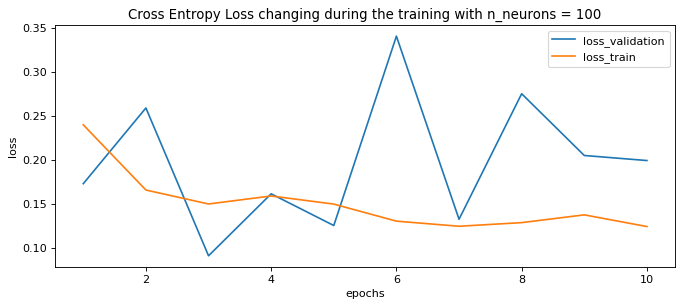

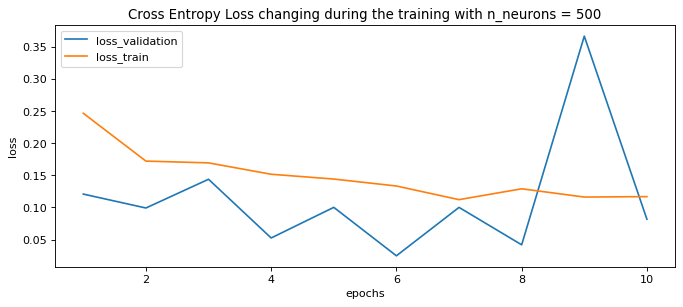

In [19]:
for i in n_neurons_list:
    loss_validation = loss_validation_dict[i]
    loss_train = loss_train_dict[i]
    plt.figure(figsize=(10, 4), dpi=80)
    plt.title('Cross Entropy Loss changing during the training with n_neurons = ' + str(i))  
    plt.plot(list(range(1, n_epoch+1)), loss_validation, label='loss_validation')
    plt.plot(list(range(1, n_epoch+1)), loss_train, label='loss_train')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend(loc='best')  
    plt.show()

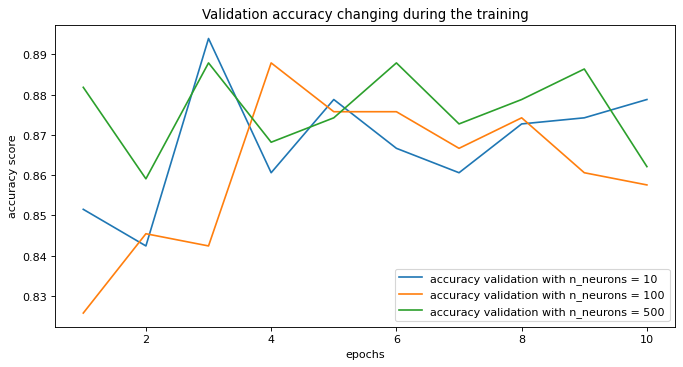

In [20]:
plt.figure(figsize=(10, 5), dpi=80)
plt.title('Validation accuracy changing during the training')  
plt.xlabel('epochs')
plt.ylabel('accuracy score')

for i in n_neurons_list:
    acc_validation = acc_validation_dict[i]
    plt.plot(list(range(1, n_epoch+1)), acc_validation, label='accuracy validation with n_neurons = ' + str(i))
plt.legend(loc='best')  
plt.show()

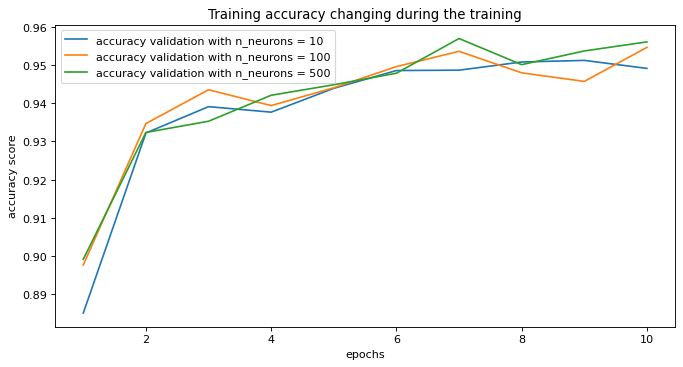

In [23]:
plt.figure(figsize=(10, 5), dpi=80)
plt.title('Training accuracy changing during the training')  
plt.xlabel('epochs')
plt.ylabel('accuracy score')

for i in n_neurons_list:
    acc_val = acc_train_dict[i]
    plt.plot(list(range(1, n_epoch+1)), acc_val, label='accuracy validation with n_neurons = ' + str(i))
plt.legend(loc='best')  
plt.show()

In [24]:
table = [list(range(1,n_epoch+1))]
columns = ['epoch']
for i, val in enumerate(n_neurons_list):
    table.append(acc_validation_dict[val])
    columns.append(str(val)+' neurons')
table = np.asarray(table).T
print('Validation accuracy change:')
pd.DataFrame(table, columns=columns)

Validation accuracy change:


,epoch,10 neurons,100 neurons,500 neurons
0,1.0,0.851515,0.825758,0.881818
1,2.0,0.842424,0.845455,0.859091
2,3.0,0.893939,0.842424,0.887879
3,4.0,0.860606,0.887879,0.868182
4,5.0,0.878788,0.875758,0.874242
5,6.0,0.866667,0.875758,0.887879
6,7.0,0.860606,0.866667,0.872727
7,8.0,0.872727,0.874242,0.878788
8,9.0,0.874242,0.860606,0.886364
9,10.0,0.878788,0.857576,0.862121


In [25]:
acc_validation_dict_1 = acc_validation_dict
acc_train_dict_1 = acc_train_dict

Самый высокий показатель accuracy на валидации показал гиперпараметр 10 на 3 эпохе обучения. Так что загрузим именно эту модель:

In [28]:
model = torchvision.models.densenet121(pretrained=True).to(device)
n_neurons = 10
# Переопредлим полносвязные слои:
fc_new =  nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1024, n_neurons),
            nn.ReLU(),
            nn.Linear(n_neurons, 2))
    
model.classifier = fc_new
wghts = torch.load(directory + '\model_DenseNet121_1_n='+str(n_neurons)+'.pth')
model.load_state_dict(wghts.state_dict())

<All keys matched successfully>

Оценим качество этой модели на test:

In [29]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for i, batch in enumerate(test_dataloader):
        image_batch, label_batch = batch
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        label_batch = torch.flatten(label_batch).type(torch.LongTensor)
        outputs = model(image_batch)
        predicted = torch.argmax(outputs, dim=1)
        
        if i==0:
            y_true_list = label_batch.numpy()
            y_pred_list = predicted.numpy()
        else:
        
            y_true_list = np.concatenate([y_true_list, label_batch.numpy()])
            y_pred_list = np.concatenate([y_pred_list, predicted.numpy()])
        
        total += label_batch.size(0)
        correct += (predicted == label_batch).sum().item()


print(f"Точность модели на test: {100 * correct / total:.2f} %")

Точность модели на test: 91.88 %


In [30]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       129
           1       0.93      0.93      0.93       191

    accuracy                           0.92       320
   macro avg       0.92      0.92      0.92       320
weighted avg       0.92      0.92      0.92       320



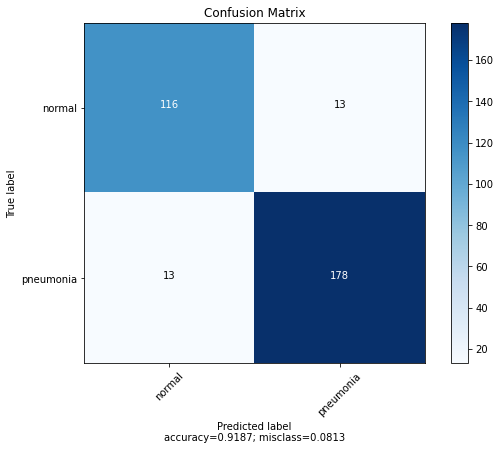

In [31]:
cm =  confusion_matrix(y_true_list, y_pred_list)

plot_confusion_matrix(cm = cm, 
                      normalize    = False,
                      target_names = ['normal','pneumonia'],
                      title        = "Confusion Matrix")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


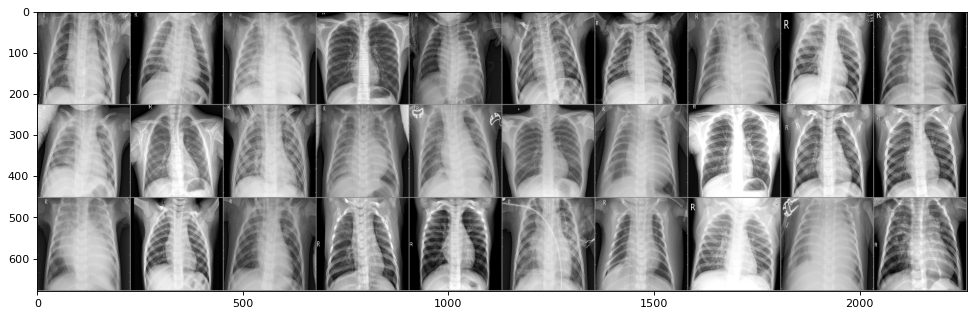

GroundTruth:  pneumonia pneumonia pneumonia  norm pneumonia  norm  norm pneumonia pneumonia pneumonia pneumonia  norm pneumonia pneumonia pneumonia  norm pneumonia  norm  norm  norm pneumonia  norm pneumonia  norm  norm pneumonia pneumonia pneumonia pneumonia pneumonia
Прогноз:  pneumonia pneumonia pneumonia norm pneumonia norm norm pneumonia pneumonia pneumonia pneumonia norm pneumonia pneumonia pneumonia norm pneumonia norm norm norm pneumonia norm pneumonia norm norm pneumonia pneumonia pneumonia pneumonia norm


In [33]:
image_batch, label_batch = next(iter(test_dataloader))
image_batch, label_batch = image_batch.to(device), label_batch.to(device)

classes = ['norm','pneumonia']
plt.figure(figsize=(15, 9), dpi=80)
imshow(torchvision.utils.make_grid(image_batch, nrow=10))
print('GroundTruth: ', ' '.join('%5s' % classes[int(label_batch[j])] for j in range(batch_size)))
outputs = model(image_batch)
predicted = torch.argmax(outputs, dim=1)

print('Прогноз: '," ".join(classes[predicted[j]]for j in range(batch_size)))

---

## №2

__Зафиксируем все сверточные слои кроме первого входного, в котором установим число входных каналов равным 1 вместо 3 + обучим полносвязные слои.__<br>
При этом я поменяю архитектуру полносвязного слоя classifier. Я сделаю один скрытый слой с числом нейронов, которое будет в качестве подбираемого гиперпараметра. Лучший гиперпараметр определим по результатам accuracy на валидационной выборке. <br>Так как я поменяю чило каналов на входе сети, поэтому могу обучать на чб снимках, размером (1, 224, 224).


In [34]:
data = datasets_bilder.preprocessing_func(easy=True)
dataset_test = data.test
dataset_train = data.train
dataset_val = data.val
mean_nums = data.mean_nums
std_nums = data.std_nums
batch_size = 30 
train_dataloader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=True, num_workers=0)

In [35]:
directory = os.getcwd() + '\models'
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def accuracy(output,labels):
    predictions = torch.argmax(output,dim=1)
    correct = (predictions == labels).sum().cpu().numpy()
    return correct / len(labels)

In [ ]:
loss_train_dict = {}
acc_train_dict = {}
acc_validation_dict = {}
loss_validation_dict = {}
neurons_list = [10,100,500]
n_epoch = 10 #Зададим число эпох обучения
start_time = time.time()
for n_neurons in neurons_list:
    
    model_2 = torchvision.models.densenet121(pretrained=True).to(device)
    
    # Переопредлим полносвязные слои:
    fc_new =  nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1024, n_neurons),
            nn.ReLU(),
            nn.Linear(n_neurons, 2))
    
    model_2.classifier = fc_new
    
    # Переопределим первый сверточный слой сети, сделав 1 входной канал
    model_2.features.conv0 =  nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)    
    
    for name, param in model_2.named_parameters():
        if not (('conv0' in name) or ('classifier' in name)):
            param.requires_grad = False
    
    loss_func = nn.CrossEntropyLoss().to(device) #Функция поторь

    opt = optim.Adam(model_2.parameters(), lr=0.001) # Адам-оптимизатор
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=5, gamma=0.1)

    # Заведем листы, в которые будем сохранять данные loss и acc эпох обучения
    loss_train = []
    acc_train = []
    acc_validation = []
    loss_validation = []

    maxacc = 0 
    print('НАЧИНАЕТСЯ ОБУЧЕНИЕ МОДЕЛИ С n_neurons =', n_neurons, ':')
    for epoch in range(n_epoch): # цикл эпох
        model_2.train()
        running_loss = 0.0
        running_acc = 0.0
        for batch in tqdm(train_dataloader):
            # получим данные батча
            image_batch, label_batch  = batch
            image_batch, label_batch = image_batch.to(device), label_batch.to(device)

            #Приведу значение label_batch к требуемому виду
            label_batch = torch.flatten(label_batch).type(torch.LongTensor) 

            # обнуление параметров градиента
            opt.zero_grad()

            # forward + backward + optimize
            y_pred = model_2(image_batch)
            loss = loss_func(y_pred, label_batch)

            loss.backward()
            opt.step()

            #среднее по так будем искать (складывать а потом делить число батчей):
            running_loss += loss.item() 
            running_acc += accuracy(y_pred, label_batch)

        print("[epoch {}] loss: {:.3}, acc: {:.3}".format(epoch+1, running_loss / len(train_dataloader),
                                                          running_acc / len(train_dataloader)))
        loss_train.append(running_loss / len(train_dataloader))
        acc_train.append(running_acc / len(train_dataloader))
        scheduler.step() # шаг для lr_scheduler

        model_2.eval()  #Перевод модели в режим тестирования
        acc_val = []
        running_loss_val = 0
        for itr,data in enumerate(val_dataloader):
                imgs = data[0].to(device)
                labels = data[1].to(device)   
                labels = torch.flatten(labels).type(torch.LongTensor)
                y_pred = model_2(imgs)
                acc_val.append(accuracy(y_pred,labels))
                running_loss_val += loss.item()
        loss_val_ep =  running_loss_val / len(val_dataloader)

        acc_val_ep = np.mean(np.array(acc_val))
        print(f'Validation accuracy - {acc_val_ep}')
        acc_validation.append(acc_val_ep)
        loss_validation.append(loss_val_ep)


        # Сохраним текущую модель лишь в случае более высокого accuracy на валидации:
        if np.mean(np.array(acc_val)) > maxacc:
                maxacc = np.mean(np.array(acc_val)) 
                torch.save(model_2, directory+'\model_DenseNet121_2_n='+str(n_neurons)+'.pth')
                
    print('ЗАВЕРШИЛОСЬ ОБУЧЕНИЕ МОДЕЛИ С n_neurons =', n_neurons)    
    
    # Добавим в словари значения изменения метрик в процессе обучения для текущего значения гиперпараметра
    loss_train_dict[n_neurons] = loss_train
    acc_train_dict[n_neurons] = acc_train
    acc_validation_dict[n_neurons] = acc_validation
    loss_validation_dict[n_neurons] = loss_validation
        
print('Total time {:.1f} seconds'.format(time.time() - start_time))

D:\Program files 2.0\Anaconda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Program files 2.0\Anaconda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


НАЧИНАЕТСЯ ОБУЧЕНИЕ МОДЕЛИ С n_neurons = 10 :


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [18:15<00:00,  6.12s/it]


[epoch 1] loss: 0.379, acc: 0.844
Validation accuracy - 0.8015151515151515


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [17:51<00:00,  5.99s/it]


[epoch 2] loss: 0.245, acc: 0.904
Validation accuracy - 0.8363636363636364


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [18:00<00:00,  6.04s/it]


[epoch 3] loss: 0.195, acc: 0.923
Validation accuracy - 0.8030303030303031


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [17:59<00:00,  6.03s/it]


[epoch 4] loss: 0.189, acc: 0.927
Validation accuracy - 0.8621212121212122


 68%|████████████████████████████████████████████████████████████████                              | 122/179 [12:16<05:51,  6.16s/it]

In [ ]:
for i in n_neurons_list:
    acc_validation = acc_validation_dict[i]
    acc_train = acc_train_dict[i]
    plt.figure(figsize=(10, 4), dpi=80)
    plt.title('Accuracy changing during the training with n_neurons = ' + str(i))  
    plt.plot(list(range(1, n_epoch+1)), acc_validation, label='acc_validation')
    plt.plot(list(range(1, n_epoch+1)), acc_train, label='acc_train')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend(loc='best')  
    plt.show()

In [ ]:
for i in n_neurons_list:
    loss_validation = loss_validation_dict[i]
    loss_train = loss_train_dict[i]
    plt.figure(figsize=(10, 4), dpi=80)
    plt.title('Cross Entropy Loss changing during the training with n_neurons = ' + str(i))  
    plt.plot(list(range(1, n_epoch+1)), loss_validation, label='loss_validation')
    plt.plot(list(range(1, n_epoch+1)), loss_train, label='loss_train')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend(loc='best')  
    plt.show()

In [ ]:
plt.figure(figsize=(10, 4), dpi=80)
plt.title('Validation accuracy changing during the training')  
plt.xlabel('epochs')
plt.ylabel('accuracy score')

for i in n_neurons_list:
    acc_validation = acc_validation_dict[i]
    plt.plot(list(range(1, n_epoch+1)), acc_validation, label='accuracy validation with n_neurons = ' + str(i))
plt.legend(loc='best')  
plt.show()

In [ ]:
plt.figure(figsize=(10, 4), dpi=80)
plt.title('Training accuracy changing during the training')  
plt.xlabel('epochs')
plt.ylabel('accuracy score')

for i in n_neurons_list:
    acc_train = acc_train_dict[i]
    plt.plot(list(range(1, n_epoch+1)), acc_train, label='accuracy validation with n_neurons = ' + str(i))
plt.legend(loc='best')  
plt.show()

In [ ]:
table = [list(range(1,n_epoch+1))]
columns = ['epoch']
for i, val in enumerate(n_neurons_list):
    table.append(acc_validation_dict[val])
    columns.append(str(val)+' neurons')
table = np.asarray(table).T
print('Validation accuracy change:')
pd.DataFrame(table, columns=columns)

In [ ]:
acc_validation_dict_2 = acc_validation_dict
acc_train_dict_2 = acc_train_dict

Самый высокий показатель accuracy на валидации показал гиперпараметр """ на """ эпохе обучения. Так что загрузим именно эту модель:

In [ ]:
model_2 = torchvision.models.densenet121(pretrained=True).to(device)
n_neurons =     
# Переопредлим полносвязные слои:
fc_new =  nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1024, n_neurons),
            nn.ReLU(),
            nn.Linear(n_neurons, 2))
    
model_2.classifier = fc_new
    
    # Переопределим первый сверточный слой сети, сделав 1 входной канал
model_2.features.conv0 =  nn.Conv2d(1, 64, kernel_size=(7, 7),
                                    stride=(2, 2), padding=(3, 3), bias=False) 
wghts = torch.load(directory + '\model_DenseNet121_2_n='+str(n_neurons)+'.pth')
model_2.load_state_dict(wghts.state_dict())

In [ ]:
Оценим качество этой модели на test:

In [ ]:
model_2.eval()
correct = 0
total = 0
with torch.no_grad():
    for i, batch in enumerate(test_dataloader):
        image_batch, label_batch = batch
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        label_batch = torch.flatten(label_batch).type(torch.LongTensor)
        outputs = model_2(image_batch)
        predicted = torch.argmax(outputs, dim=1)
        
        if i==0:
            y_true_list = label_batch.numpy()
            y_pred_list = predicted.numpy()
        else:
        
            y_true_list = np.concatenate([y_true_list, label_batch.numpy()])
            y_pred_list = np.concatenate([y_pred_list, predicted.numpy()])
        
        total += label_batch.size(0)
        correct += (predicted == label_batch).sum().item()


print(f"Точность модели на test: {100 * correct / total:.2f} %")

In [ ]:
print(classification_report(y_true_list, y_pred_list))

In [ ]:
cm =  confusion_matrix(y_true_list, y_pred_list)

plot_confusion_matrix(cm = cm, 
                      normalize    = False,
                      target_names = ['normal','pneumonia'],
                      title        = "Confusion Matrix")

In [ ]:
classes = ['norm','pneumonia']
image_batch, label_batch = next(iter(test_dataloader))
image_batch, label_batch = image_batch.to(device), label_batch.to(device)

plt.figure(figsize=(15, 9), dpi=80)
imshow(torchvision.utils.make_grid(image_batch, nrow=10))
print('GroundTruth: ', ' '.join('%5s' % classes[int(label_batch[j])] for j in range(batch_size)))
outputs = model_2(image_batch)
predicted = torch.argmax(outputs, dim=1)

print('Прогноз: '," ".join(classes[predicted[j]]for j in range(batch_size)))

## №3

__Полностью обучим сеть, ничего в ней не меняя (кроме выходного числа нейронов в полносвязной части).__ <br>
Так как фотки исходные чб, то при создании датасетов буду включать параметр RGB_presentation = True, который сделает входные фотки размером (3, 224, 224)

In [ ]:
data = datasets_bilder.preprocessing_func(RGB_presentation=True, easy=True)
dataset_test = data.test
dataset_train = data.train
dataset_val = data.val
mean_nums = data.mean_nums
std_nums = data.std_nums
batch_size = 30 
train_dataloader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=True, num_workers=0)

In [ ]:
n_epoch = 10

In [ ]:
directory = os.getcwd() + '\models'
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def accuracy(output,labels):
    predictions = torch.argmax(output,dim=1)
    correct = (predictions == labels).sum().cpu().numpy()
    return correct / len(labels)

In [ ]:
model_3 = torchvision.models.densenet121(pretrained=True).to(device)

# Переопредлим полносвязные слои:
fc_new =  nn.Sequential(
                nn.Linear(1024, 2))
model_3.classifire = fc_new
    
for name, param in model_3.named_parameters():
    param.requires_grad = True

loss_func = nn.CrossEntropyLoss().to(device) #Функция поторь

opt = optim.Adam(model_3.parameters(), lr=0.001) # Адам-оптимизатор
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=5, gamma=0.1)   

# Заведем листы, в которые будем сохранять данные loss и acc эпох обучения
loss_train = []
acc_train = []
acc_validation = []
loss_validation = []

start_time = time.time()
maxacc = 0 
for epoch in range(n_epoch): # цикл эпох
    model_3.train() # Перевод модели в режим обучения
    running_loss = 0.0
    running_acc = 0.0
    for batch in tqdm(train_dataloader):
        # получим данные батча
        image_batch, label_batch  = batch
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        
        #Приведу значение label_batch к требуемому виду
        label_batch = torch.flatten(label_batch).type(torch.LongTensor) 
        
        # обнуление параметров градиента
        opt.zero_grad()

        # forward + backward + optimize
        y_pred = model_3(image_batch)
        loss = loss_func(y_pred, label_batch)
        
        loss.backward()
        opt.step()
        
        #среднее по так будем искать (складывать а потом делить число батчей):
        running_loss += loss.item() 
        running_acc += accuracy(y_pred, label_batch)
        
    print("[epoch {}] loss: {:.3}, acc: {:.3}".format(epoch+1, running_loss / len(train_dataloader),
                                                      running_acc / len(train_dataloader)))
    loss_train.append(running_loss / len(train_dataloader))
    acc_train.append(running_acc / len(train_dataloader))
    scheduler.step() # шаг для lr_scheduler

    model_3.eval()  #Перевод модели в режим тестирования
    acc_val = []
    running_loss_val = 0
    for itr,data in enumerate(val_dataloader):
            imgs = data[0].to(device)
            labels = data[1].to(device)   
            labels = torch.flatten(labels).type(torch.LongTensor)
            y_pred = model_3(imgs)
            acc_val.append(accuracy(y_pred,labels))
            running_loss_val += loss.item()
    loss_val_ep =  running_loss_val / len(val_dataloader)

    acc_val_ep = np.mean(np.array(acc_val))
    print(f'Validation accuracy - {acc_val_ep}')
    acc_validation.append(acc_val_ep)
    loss_validation.append(loss_val_ep)

    
    # Сохраним текущую модель лишь в случае более высокого accuracy на валидации:
    if np.mean(np.array(acc_val)) > maxacc:
            maxacc = np.mean(np.array(acc_val)) 
            torch.save(model_3, directory+'\model_DenseNet121_full_train.pth')
            
print('Total time {:.3f} seconds'.format(time.time() - start_time))

In [ ]:
n_epoch = 10
plt.figure(figsize=(10, 4), dpi=80)
plt.title('Accuracy changing during the training')  
plt.plot(list(range(1, n_epoch+1)), acc_validation, label='acc_validation')
plt.plot(list(range(1, n_epoch+1)), acc_train, label='acc_train')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc='best')  
plt.show()

In [ ]:
plt.figure(figsize=(10, 4), dpi=80)
plt.title('Cross Entropy Loss changing during the training ')  
plt.plot(list(range(1, n_epoch+1)), loss_validation, label='loss_validation')
plt.plot(list(range(1, n_epoch+1)), loss_train, label='loss_train')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='best')  
plt.show()

In [ ]:
wghts = torch.load(directory + '\model_DenseNet121_full_train.pth')
model_3.load_state_dict(wghts.state_dict())

In [ ]:
model_3.eval()
correct = 0
total = 0
with torch.no_grad():
    for i, batch in enumerate(test_dataloader):
        image_batch, label_batch = batch
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        label_batch = torch.flatten(label_batch).type(torch.LongTensor)
        outputs = model_3(image_batch)
        predicted = torch.argmax(outputs, dim=1)
        
        if i==0:
            y_true_list = label_batch.numpy()
            y_pred_list = predicted.numpy()
        else:
        
            y_true_list = np.concatenate([y_true_list, label_batch.numpy()])
            y_pred_list = np.concatenate([y_pred_list, predicted.numpy()])
        
        total += label_batch.size(0)
        correct += (predicted == label_batch).sum().item()


print(f"Точность модели на test: {100 * correct / total:.2f} %")

In [ ]:
print(classification_report(y_true_list, y_pred_list))

In [ ]:
cm =  confusion_matrix(y_true_list, y_pred_list)

plot_confusion_matrix(cm = cm, 
                      normalize    = False,
                      target_names = ['normal','pneumonia'],
                      title        = "Confusion Matrix")

In [ ]:
acc_train_full = acc_train 
acc_validation_full = acc_validation 

### №3.1 Обучение полной модели без загрузки предобученных весов

In [ ]:
model_3 = torchvision.models.densenet121(pretrained=False).to(device)

# Переопредлим полносвязные слои:
fc_new =  nn.Sequential(
                nn.Linear(1024, 2))
model_3.classifire = fc_new
    
for name, param in model_3.named_parameters():
    param.requires_grad = True

loss_func = nn.CrossEntropyLoss().to(device) #Функция поторь

opt = optim.Adam(model_3.parameters(), lr=0.001) # Адам-оптимизатор
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=5, gamma=0.1)   

# Заведем листы, в которые будем сохранять данные loss и acc эпох обучения
loss_train = []
acc_train = []
acc_validation = []
loss_validation = []

start_time = time.time()
maxacc = 0 
for epoch in range(n_epoch): # цикл эпох
    model_3.train() # Перевод модели в режим обучения
    running_loss = 0.0
    running_acc = 0.0
    for batch in tqdm(train_dataloader):
        # получим данные батча
        image_batch, label_batch  = batch
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        
        #Приведу значение label_batch к требуемому виду
        label_batch = torch.flatten(label_batch).type(torch.LongTensor) 
        
        # обнуление параметров градиента
        opt.zero_grad()

        # forward + backward + optimize
        y_pred = model_3(image_batch)
        loss = loss_func(y_pred, label_batch)
        
        loss.backward()
        opt.step()
        
        #среднее по так будем искать (складывать а потом делить число батчей):
        running_loss += loss.item() 
        running_acc += accuracy(y_pred, label_batch)
        
    print("[epoch {}] loss: {:.3}, acc: {:.3}".format(epoch+1, running_loss / len(train_dataloader),
                                                      running_acc / len(train_dataloader)))
    loss_train.append(running_loss / len(train_dataloader))
    acc_train.append(running_acc / len(train_dataloader))
    scheduler.step() # шаг для lr_scheduler

    model_3.eval()  #Перевод модели в режим тестирования
    acc_val = []
    running_loss_val = 0
    for itr,data in enumerate(val_dataloader):
            imgs = data[0].to(device)
            labels = data[1].to(device)   
            labels = torch.flatten(labels).type(torch.LongTensor)
            y_pred = model_3(imgs)
            acc_val.append(accuracy(y_pred,labels))
            running_loss_val += loss.item()
    loss_val_ep =  running_loss_val / len(val_dataloader)

    acc_val_ep = np.mean(np.array(acc_val))
    print(f'Validation accuracy - {acc_val_ep}')
    acc_validation.append(acc_val_ep)
    loss_validation.append(loss_val_ep)

    
    # Сохраним текущую модель лишь в случае более высокого accuracy на валидации:
    if np.mean(np.array(acc_val)) > maxacc:
            maxacc = np.mean(np.array(acc_val)) 
            torch.save(model_3, directory+'\model_DenseNet121_full_train.pth')
            
print('Total time {:.3f} seconds'.format(time.time() - start_time))

In [ ]:
plt.figure(figsize=(10, 4), dpi=80)
plt.title('Accuracy changing during the training')  
plt.plot(list(range(1, n_epoch+1)), acc_validation, label='acc_validation')
plt.plot(list(range(1, n_epoch+1)), acc_train, label='acc_train')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc='best')  
plt.show()

In [ ]:

plt.figure(figsize=(10, 4), dpi=80)
plt.title('Cross Entropy Loss changing during the training ')  
plt.plot(list(range(1, n_epoch+1)), loss_validation, label='loss_validation')
plt.plot(list(range(1, n_epoch+1)), loss_train, label='loss_train')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='best')  
plt.show()

In [ ]:
wghts = torch.load(directory + '\model_ResNet18_no_TL.pth')
model_3.load_state_dict(wghts.state_dict())

In [ ]:
model_3.eval()
correct = 0
total = 0
with torch.no_grad():
    for i, batch in enumerate(test_dataloader):
        image_batch, label_batch = batch
        image_batch, label_batch = image_batch.to(device), label_batch.to(device)
        label_batch = torch.flatten(label_batch).type(torch.LongTensor)
        outputs = model_3(image_batch)
        predicted = torch.argmax(outputs, dim=1)
        
        if i==0:
            y_true_list = label_batch.numpy()
            y_pred_list = predicted.numpy()
        else:
        
            y_true_list = np.concatenate([y_true_list, label_batch.numpy()])
            y_pred_list = np.concatenate([y_pred_list, predicted.numpy()])
        
        total += label_batch.size(0)
        correct += (predicted == label_batch).sum().item()


print(f"Точность модели на test: {100 * correct / total:.2f} %")

In [ ]:
print(classification_report(y_true_list, y_pred_list))

---

__Общеее сравнение DenseNet Transfer Learning__

In [ ]:
n_epoch = 10
plt.figure(figsize=(14, 8), dpi=80)
plt.title('Validation accuracy in various types of ResNet training')  
plt.plot(list(range(1, n_epoch+1)), acc_validation_dict_1[10], label='I - 10 neurons', color='orange')
plt.plot(list(range(1, n_epoch+1)), acc_validation_dict_1[100], label='I - 100 neurons',color='lime')
plt.plot(list(range(1, n_epoch+1)), acc_validation_dict_1[500], label='I - 500 neurons',color='skyblue')
plt.plot(list(range(1, n_epoch+1)), acc_validation_dict_2[10], label='II - 10 neurons',color='m')
plt.plot(list(range(1, n_epoch+1)), acc_validation_dict_2[100], label='II - 100 neurons',color='blue')
plt.plot(list(range(1, n_epoch+1)), acc_validation_dict_2[500], label='II - 500 neurons',color='red')
plt.plot(list(range(1, n_epoch+1)), acc_validation_full[:10] , label='full training (pretrained = True)',color='k')    
plt.plot(list(range(1, n_epoch+1)), acc_validation[:10] , label='full training (pretrained = False)',color='green') 
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc='best')  
plt.show()

In [ ]:
n_epoch = 10
plt.figure(figsize=(14, 8), dpi=80)
plt.title('Accuracy on the training dataset for various types of ResNet training')  
plt.plot(list(range(1, n_epoch+1)), acc_train_dict_1[10], label='I - 10 neurons',  color='orange')
plt.plot(list(range(1, n_epoch+1)), acc_train_dict_1[100], label='I - 100 neurons',color='lime')
plt.plot(list(range(1, n_epoch+1)), acc_train_dict_1[500], label='I - 500 neurons',color='skyblue')
plt.plot(list(range(1, n_epoch+1)), acc_train_dict_2[10], label='II - 10 neurons',color='m')
plt.plot(list(range(1, n_epoch+1)), acc_train_dict_2[100], label='II - 100 neurons',color='blue')
plt.plot(list(range(1, n_epoch+1)), acc_train_dict_2[500], label='II - 500 neurons',color='red')
plt.plot(list(range(1, n_epoch+1)), acc_train_full[:10] , label='full training (pretrained = True)',color='k')  
plt.plot(list(range(1, n_epoch+1)), acc_train[:10] , label='full training (pretrained = False)',color='green') 
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc='best')  
plt.show()

### Вывод:

В данном проекте было проведено исследование применения transfer learning для решения задачи бинарной классификации рентгеновских снимков. В данном случае использовалась предобученная сеть DenseNet121. Было проведено три эксперимента, в которых сравнивались результаты обучения при использовании разных подходов к переносу обучения
( 1 - мы обучали лишь полносвязную часть, 2 - полносвязную часть с первым сверточным слоем, 3 - обучали сеть целиком ) .